In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import random_split, DataLoader, Dataset, ConcatDataset
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report

# Calculo de similaridade
from sklearn.metrics.pairwise import cosine_similarity
from scipy.stats import pearsonr
from scipy.spatial.distance import euclidean
from scipy.spatial.distance import cityblock
from sklearn.metrics import jaccard_score

import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import seaborn as sns

# Define seed
SEED = 42

# Set the seed for reproducibility
torch.manual_seed(SEED)
np.random.seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)  # For multi-GPU setups
torch.backends.cudnn.deterministic = True  # Ensure deterministic behavior
torch.backends.cudnn.benchmark = False    # Disable if you want deterministic results

Feature_ambos = [
                #'L4_SRC_PORT',
                #'L4_DST_PORT',
                'PROTOCOL',
                #'L7_PROTO',
                'IN_BYTES',
                'IN_PKTS',
                'OUT_BYTES',
                'OUT_PKTS',
                #'TCP_FLAGS',
                #'CLIENT_TCP_FLAGS',
                #'SERVER_TCP_FLAGS',
                'FLOW_DURATION_MILLISECONDS',
                'DURATION_IN', 
                'DURATION_OUT',
                #'MIN_TTL', 
                #'MAX_TTL',
                'LONGEST_FLOW_PKT',
                #'SHORTEST_FLOW_PKT',
                #'MIN_IP_PKT_LEN', 
                'MAX_IP_PKT_LEN', 
                'SRC_TO_DST_SECOND_BYTES', 
                'DST_TO_SRC_SECOND_BYTES',
                'RETRANSMITTED_IN_BYTES', 
                'RETRANSMITTED_IN_PKTS', 
                'RETRANSMITTED_OUT_BYTES', 
                'RETRANSMITTED_OUT_PKTS',
                'SRC_TO_DST_AVG_THROUGHPUT', 
                'DST_TO_SRC_AVG_THROUGHPUT', 
                'NUM_PKTS_UP_TO_128_BYTES',
                'NUM_PKTS_128_TO_256_BYTES', 
                'NUM_PKTS_256_TO_512_BYTES', 
                'NUM_PKTS_512_TO_1024_BYTES',
                'NUM_PKTS_1024_TO_1514_BYTES', 
                #'TCP_WIN_MAX_IN', 
                #'TCP_WIN_MAX_OUT', 
                'ICMP_TYPE', 
                'ICMP_IPV4_TYPE',
                #'DNS_QUERY_ID', 
                'DNS_QUERY_TYPE', 
                #'DNS_TTL_ANSWER',
                #'FTP_COMMAND_RET_CODE',
                'Label', 
                'Attack']

Feature_name = [f for f in Feature_ambos if f not in ['Label', 'Attack']]

input_dim = 26

# Mapear todos os ataques
# Mapear todos os ataques
map_attacks = {'Benign':0, 
              'DoS':1,
              'dos':1,
              'Reconnaissance':2,
              'DDoS':3,
              'ddos':3,
              'Theft':4,
              'ransomware':5,
              'scanning':6,
              'xss':7,
              'mitm':8,
              'password':9,
              'Backdoor':10,
              'backdoor':10,
              'Analysis':11,
              'Generic':12,
              'Exploits':13,
              'Bot':14,
              'DoS_attacks-SlowHTTPTest':15,
              'SSH-Bruteforce':16,
              'DoS_attacks-Hulk':17,
              'Infilteration':18,
              'DDOS_attack-HOIC':19, 
              'FTP-BruteForce':20,
              'Brute_Force_-Web':21, 
              'DDoS_attacks-LOIC-HTTP':22, 
              'DoS_attacks-GoldenEye':23,
              'DDOS_attack-LOIC-UDP':24, 
              'DoS_attacks-Slowloris':25, 
              'Brute_Force_-XSS':26,
              'SQL_Injection':27
              }

In [2]:
class AE1(nn.Module):
    def __init__(self, input_dim, latent_dim=32):
        super(AE1, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 512), nn.ReLU(),
            nn.Linear(512, 256), nn.ReLU(),
            nn.Linear(256, 128), nn.ReLU(),
            nn.Linear(128, 64), nn.ReLU(),
            nn.Linear(64, latent_dim), nn.ReLU(),
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 64), nn.ReLU(),
            nn.Linear(64, 128), nn.ReLU(),
            nn.Linear(128, 256), nn.ReLU(),
            nn.Linear(256, 512), nn.ReLU(),
            nn.Linear(512, input_dim)
        )

    def forward(self, x):
        x_enc = self.encoder(x)
        recon = self.decoder(x_enc)
        return recon, x_enc

In [3]:
class AE2(nn.Module):
    def __init__(self, input_dim, latent_dim=32, dropout_rate=0.2):
        super(AE2, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 512), nn.PReLU(), nn.Dropout(dropout_rate),
            nn.Linear(512, 256), nn.PReLU(), nn.Dropout(dropout_rate),
            nn.Linear(256, 128), nn.PReLU(), nn.Dropout(dropout_rate),
            nn.Linear(128, 64), nn.PReLU(), nn.Dropout(dropout_rate),
            nn.Linear(64, latent_dim)
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 64), nn.PReLU(), nn.Dropout(dropout_rate),
            nn.Linear(64, 128), nn.PReLU(), nn.Dropout(dropout_rate),
            nn.Linear(128, 256), nn.PReLU(), nn.Dropout(dropout_rate),
            nn.Linear(256, 512), nn.PReLU(), nn.Dropout(dropout_rate),
            nn.Linear(512, input_dim)
        )

    def forward(self, x):
        x_enc = self.encoder(x)
        recon = self.decoder(x_enc)
        return recon, x_enc

In [4]:
def ae_loss(recon_x, x):
    recon_loss = F.mse_loss(recon_x, x, reduction='sum')
    return recon_loss

In [5]:
class MLP(nn.Module):
    def __init__(self, latent_dim):
        super(MLP, self).__init__()
        self.mlp = nn.Sequential(
            nn.Linear(latent_dim, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(True),
            nn.Dropout(0.3),

            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(True),
            nn.Dropout(0.3),

            nn.Linear(256, 64),
            nn.ReLU(True),
            nn.Dropout(0.2),

            nn.Linear(64, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.mlp(x)

In [6]:
def get_datasets(dataset):
    
    if dataset == "dataset1":
         df = pd.read_csv('datasets/dataset1v2.csv') # NF-BoT-IoT-v2
    if dataset == "dataset2":
         df = pd.read_csv('datasets/dataset2v2.csv') # NF-ToN-IoT-v2
    if dataset == "dataset3":
         df = pd.read_csv('datasets/dataset3v2.csv') # NF-UNSW-NB15-v2
    if dataset == "dataset4":
         df = pd.read_csv('datasets/dataset4v2.csv') # NF-CICIDS2018-v3

    dataframe = df[Feature_ambos]
    
    return dataframe

In [7]:
def preprocessing_data(df):
    df_split = df.copy()
    df_split_label = df_split['Attack']
    df_split = df_split.drop('Attack',axis=1)
    df_split = df_split.drop('Label',axis=1)
    
    # Inicializando o MinMaxScaler (intervalo padrão é [0, 1])
    scaler = MinMaxScaler()

    # Ajustando e transformando os dados
    df_split = scaler.fit_transform(df_split)
    
    df_split_label = df_split_label.to_frame()
    x_split_train, x_split_temp, y_split_train, y_split_temp = train_test_split(df_split, df_split_label, test_size = 0.30, stratify=df_split_label)
    x_split_test, x_split_val, y_split_test, y_split_val = train_test_split(x_split_temp, y_split_temp, test_size = 0.50, stratify=y_split_temp)
    y_split_train['Attack'] = y_split_train['Attack'].apply(lambda x: 0 if x == 'Benign' else 1)
    z_split_test = y_split_test.copy()
    y_split_test['Attack'] = y_split_test['Attack'].apply(lambda x: 0 if x == 'Benign' else 1)
    #print(z_split_test)
    z_split_test['Attack']=z_split_test['Attack'].map(map_attacks)
    #z_test = torch.tensor(np.array(z_split_test, dtype=np.float32), dtype = torch.float)
    class_test = torch.tensor(np.array(y_split_test, dtype=np.float32), dtype = torch.float)
    class_attack = torch.tensor(np.array(z_split_test, dtype=np.float32), dtype = torch.float)
    dataset = torch.utils.data.TensorDataset(class_attack, class_test)
    z_test = torch.utils.data.DataLoader(dataset, batch_size=41)
    #print(z_split_test)
    y_split_val['Attack'] = y_split_val['Attack'].apply(lambda x: 0 if x == 'Benign' else 1)
    return x_split_train, y_split_train, x_split_val, y_split_val, x_split_test, y_split_test, z_test

In [8]:
def tensor_data(x_source1_train, y_source1_train):
    previsores_train = torch.tensor(np.array(x_source1_train), dtype = torch.float)
    class_train = torch.tensor(np.array(y_source1_train, dtype=np.float32), dtype = torch.float)
    dataset = torch.utils.data.TensorDataset(previsores_train, class_train)
    train_loader = torch.utils.data.DataLoader(dataset, batch_size=41)
    return previsores_train, class_train, dataset, train_loader

In [9]:
def inicia_datasets(treino):
      df = get_datasets(treino)
      print(f"Prepara {treino}: {df.shape}")
      x_split_train, y_split_train, x_split_val, y_split_val, x_split_test, y_split_test, z_split_test = preprocessing_data(df)
      print( x_split_train.shape, y_split_train.shape)
      print( x_split_val.shape, y_split_val.shape)
      print( x_split_test.shape, y_split_test.shape)
      dataset_train, class_train, dataset_train, loader_train = tensor_data( x_split_train,  y_split_train)
      dataset_val, class_val, dataset_val, loader_val = tensor_data( x_split_val,  y_split_val)
      dataset_test, class_test, dataset_test, loader_test = tensor_data( x_split_test,  y_split_test)
      return dataset_train, class_train, dataset_train, loader_train, dataset_val, class_val, dataset_val, loader_val, dataset_test, class_test, dataset_test, loader_test, z_split_test

In [10]:
dataset = "dataset1" 
dataset_train1, class_train1, dataset_train1, loader_train1, dataset_val1, class_val1, dataset_val1, loader_val1, dataset_test1, class_test1, dataset_test1, loader_test1, z_split_test1 = inicia_datasets(dataset)
dataset = "dataset2" 
dataset_train2, class_train2, dataset_train2, loader_train2, dataset_val2, class_val2, dataset_val2, loader_val2, dataset_test2, class_test2, dataset_test2, loader_test2, z_split_test2 = inicia_datasets(dataset)
dataset = "dataset3" 
dataset_train3, class_train3, dataset_train3, loader_train3, dataset_val3, class_val3, dataset_val3, loader_val3, dataset_test3, class_test3, dataset_test3, loader_test3, z_split_test3 = inicia_datasets(dataset)
dataset = "dataset4" 
dataset_train4, class_train4, dataset_train4, loader_train4, dataset_val4, class_val4, dataset_val4, loader_val4, dataset_test4, class_test4, dataset_test4, loader_test4, z_split_test4 = inicia_datasets(dataset)

# Gerar ambos para teste e validação
test_dataset_combined = ConcatDataset([dataset_test1, dataset_test2, dataset_test3, dataset_test4])
test_loader_combined = DataLoader(test_dataset_combined, batch_size=loader_test1.batch_size, shuffle=True)
val_dataset_combined = ConcatDataset([dataset_val1, dataset_val2, dataset_val3, dataset_val4])
val_loader_combined = DataLoader(val_dataset_combined, batch_size=loader_val1.batch_size, shuffle=True)

Prepara dataset1: (224511, 28)
(157157, 26) (157157, 1)
(33677, 26) (33677, 1)
(33677, 26) (33677, 1)
Prepara dataset2: (224512, 28)
(157158, 26) (157158, 1)
(33677, 26) (33677, 1)
(33677, 26) (33677, 1)
Prepara dataset3: (142152, 28)
(99506, 26) (99506, 1)
(21323, 26) (21323, 1)
(21323, 26) (21323, 1)
Prepara dataset4: (223976, 28)
(156783, 26) (156783, 1)
(33597, 26) (33597, 1)
(33596, 26) (33596, 1)


In [11]:
def treina_modelo(modelo_AE1, modelo_AE2, modelo_MLP, input_dim, device):

    from sklearn.metrics import classification_report
    import matplotlib.pyplot as plt
    
    # Hiperparâmetros
    num_classes = 2
    epochs = 600
    lr = 0.001

    Alpha = 0.2
    Beta = 1
    Gama = 0.2
    
    patience = 50
    best_val_acc = 0
    epochs_no_improve = 0
    best_model_state = None
  
    # Otimizador conjunto
    params = list(modelo_MLP.parameters()) + list(modelo_AE1.parameters()) + list(modelo_AE2.parameters())   
    optimizer = torch.optim.Adam(params, lr=lr)

    # Scheduler: reduz o learning rate se a acurácia parar de melhorar
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=20, factor=0.6)

    # Funções de perda
    class_loss_fn = nn.BCEWithLogitsLoss()

    # Histórico
    loss_vals = []
    loss_valsAE = []
    loss_valsMLP = []
    dissim_cos_12 = []
    dissim_euc_12 = []
    val_accuracies = []
    val_losses = []

    Z_AE1 = []
    Z_AE2 = []
    
    for epoch in range(epochs):
        
        modelo_AE1.train()
        modelo_AE2.train()
        modelo_MLP.train()

        epoch_loss_recon = []
        epoch_loss_class = []
        epoch_loss_val = []
        epoch_simC = []
        epoch_corr = []
        epoch_distE = []
        epoch_distM = []
        epoch_simJ = []
        
        # Variaveis para similaridade
        simC = 0  # Cosseno 
        corr = 0  # Pearson 1.0 Correlação perfeita
        distE = 0  #  Eculidiana - Distância euclidiana
        distM = 0  # Distância de Manhattan
        simJ = 0  # Similaridade de Jaccard (para vetores binários ou conjuntos)

        for (X1, y1), (X2, y2), (X3, y3), (X4, y4) in zip(loader_train1, loader_train2, loader_train3, loader_train4):
    
            X = torch.cat([X1, X2, X3, X4], dim=0).to(device)
            y = torch.cat([y1, y2, y3, y4], dim=0).to(device).float()
            y = y.view(-1, 1)
            
            optimizer.zero_grad()
            
            # Forward do VAE1
            recon1, x_latent1 = modelo_AE1(X)
            
            # Forward do VAE2
            recon2, x_latent2 = modelo_AE2(X)

            # Perda de reconstrução (VAE1)
            recon_loss1 = ae_loss(recon1, X)
            
            # Perda de reconstrução (VAE2)
            recon_loss2 = ae_loss(recon2, X)

            # Cálculo das dissimilaridades
            cos12 = 1 - F.cosine_similarity(x_latent1, x_latent2, dim=1).mean().item()

            Z_AE1.append(x_latent1)
            Z_AE2.append(x_latent2)
        
            euc12 = torch.norm(x_latent1 - x_latent2, dim=1).mean().item()
            
            # Classificação com vetor latente
            x_latent = torch.cat([x_latent1, x_latent2], dim=1)
            outputs = modelo_MLP(x_latent)
            loss_class = F.binary_cross_entropy(outputs, y)

            # Perda total
            loss_recon = (recon_loss1 + recon_loss2)/2

            # Diversidade entre representações (distância entre vetores latentes)
            loss_diss = (F.mse_loss(x_latent1, x_latent2))

            total_loss =  ( loss_recon * Alpha ) + ( loss_class * Beta ) + ( loss_diss * Gama )

            total_loss.backward()
            optimizer.step()

            epoch_loss_recon.append(recon_loss1.item())
            epoch_loss_recon.append(recon_loss2.item())
            epoch_loss_class.append(loss_class.item())
        
            # Acumular por época
            if epoch == len(dissim_cos_12):  # só adiciona uma vez por época
                dissim_cos_12.append(cos12)
                dissim_euc_12.append(euc12)
       
        # === Logs da época ===
        loss_epoch_recon = sum(epoch_loss_recon) / len(epoch_loss_recon)
        loss_epoch_class = sum(epoch_loss_class) / len(epoch_loss_class)
        
        loss_valsAE.append(loss_epoch_recon)
        loss_valsMLP.append(loss_epoch_class)
        
        print(f"Epoch {epoch+1:02d}/{epochs} | Recon: {loss_epoch_recon:.4f} | Class: {loss_epoch_class:.4f}")
        modelo_AE1.eval()
        modelo_AE2.eval()
        modelo_MLP.eval()
        all_preds, all_labels = [], []
        
        with torch.no_grad():
            
           for (X1, y1), (X2, y2), (X3, y3), (X4, y4) in zip(loader_val1, loader_val2, loader_val3, loader_val4):
    
               X = torch.cat([X1, X2, X3, X4], dim=0).to(device)
               y = torch.cat([y1, y2, y3, y4], dim=0).to(device).float()
               y = y.view(-1, 1)
            
               optimizer.zero_grad()
            
               # Forward do VAE1, VAE2
               recon1, x_latent1 = modelo_AE1(X)
               recon2, x_latent2 = modelo_AE2(X)
            
               # Classificação com vetor latente
               x_latent = torch.cat([x_latent1, x_latent2], dim=1)
               outputs = modelo_MLP(x_latent)
               loss_class = F.binary_cross_entropy(outputs, y)
               
               preds = (outputs > 0.5).float()

               # Calcula loss (BCE para binário)
               loss = F.binary_cross_entropy(outputs, y)
               
               epoch_loss_val.append(loss.item())
               
               all_preds.append(preds.cpu())
               all_labels.append(y.cpu())

        all_preds_list = torch.cat(all_preds)
        all_labels_list = torch.cat(all_labels)
        acc = (all_preds_list.view(-1) == all_labels_list.view(-1)).float().mean().item()
        loss_val = sum(epoch_loss_val) / len(epoch_loss_val)
    
        val_accuracies.append(acc)
        val_losses.append(loss_val)
        print(f"Acurácia: {acc}")

        # Atualiza scheduler com base na acurácia de validação
        scheduler.step(acc)

        # Mostra o learning rate atual
        for param_group in optimizer.param_groups:
            current_lr = param_group['lr']
        print(f"Learning Rate atual: {current_lr:.6f}")        

        # Early stopping
        if acc > best_val_acc:
            best_val_acc = acc
            epochs_no_improve = 0
            best_model_state = modelo_MLP.state_dict()
        else:
            epochs_no_improve += 1
            print(f"Sem melhoria na validação por {epochs_no_improve} época(s).")
            if epochs_no_improve >= patience:
                print(f"Early stopping ativado na época {epoch+1}")
                break

    # Restaurar melhor modelo
    if best_model_state is not None:
        modelo_MLP.load_state_dict(best_model_state)
        print("Melhor modelo MLP restaurado com base na menor perda de validação.")  
        
    # === Plots ===
    plt.plot(loss_valsAE, label='Autoencoder')
    plt.plot(loss_valsMLP, label='MLP')
    plt.title('Treinamento - Perdas')
    plt.xlabel('Épocas')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.plot(val_losses, label='MLP')
    plt.title('Validação: Perdas')
    plt.xlabel('Épocas')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # Acurácia
    plt.subplot(1,2,2)
    plt.plot(val_accuracies, label='Validação', color='green')
    plt.title('Validação: Acurácia x Época')
    plt.xlabel('Época')
    plt.ylabel('Acurácia')
    plt.legend()
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(12, 4))

    # Dissimilaridade Cosseno
    plt.subplot(1, 2, 1)
    plt.plot(dissim_cos_12, label='AE1 vs AE2')
    plt.title('Dissimilaridade - Cosseno (1 - Similaridade)')
    plt.xlabel('Época')
    plt.ylabel('Distância Cosseno')
    plt.legend()
    plt.grid(True)

    # Dissimilaridade Euclidiana
    plt.subplot(1, 2, 2)
    plt.plot(dissim_euc_12, label='AE1 vs AE2')
    plt.title('Dissimilaridade - Distância Euclidiana')
    plt.xlabel('Época')
    plt.ylabel('Distância')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    return  all_preds, all_labels, Z_AE1, Z_AE2

In [12]:
# Instanciando o modelo
latent_dim = 64
modelo_AE1 = AE1(input_dim)
modelo_AE2 = AE2(input_dim)
modelo_MLP = MLP(latent_dim)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Epoch 01/600 | Recon: 4.0387 | Class: 0.4795
Acurácia: 0.7684354782104492
Learning Rate atual: 0.001000
Epoch 02/600 | Recon: 1.1825 | Class: 0.3809
Acurácia: 0.8328922986984253
Learning Rate atual: 0.001000
Epoch 03/600 | Recon: 0.9960 | Class: 0.3340
Acurácia: 0.85683673620224
Learning Rate atual: 0.001000
Epoch 04/600 | Recon: 0.9161 | Class: 0.2979
Acurácia: 0.8860384225845337
Learning Rate atual: 0.001000
Epoch 05/600 | Recon: 0.8360 | Class: 0.2755
Acurácia: 0.8895511031150818
Learning Rate atual: 0.001000
Epoch 06/600 | Recon: 0.8074 | Class: 0.2611
Acurácia: 0.8965529203414917
Learning Rate atual: 0.001000
Epoch 07/600 | Recon: 0.7887 | Class: 0.2480
Acurácia: 0.9026532173156738
Learning Rate atual: 0.001000
Epoch 08/600 | Recon: 0.7582 | Class: 0.2385
Acurácia: 0.8637800812721252
Learning Rate atual: 0.001000
Sem melhoria na validação por 1 época(s).
Epoch 09/600 | Recon: 0.7461 | Class: 0.2290
Acurácia: 0.9080743789672852
Learning Rate atual: 0.001000
Epoch 10/600 | Recon: 0.

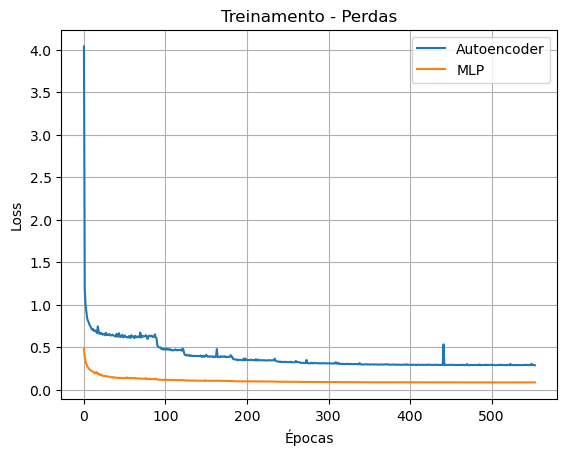

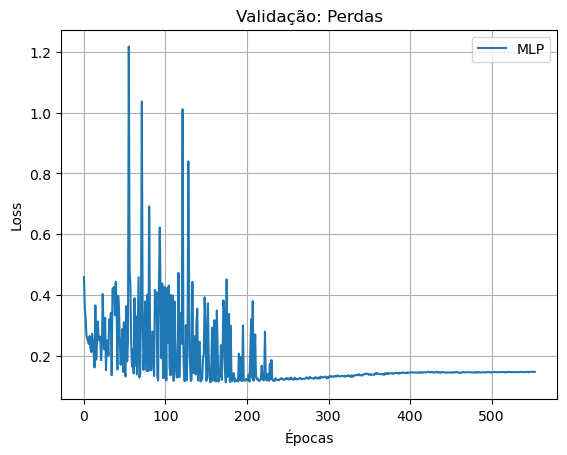

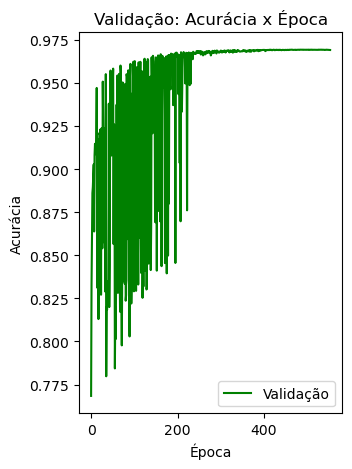

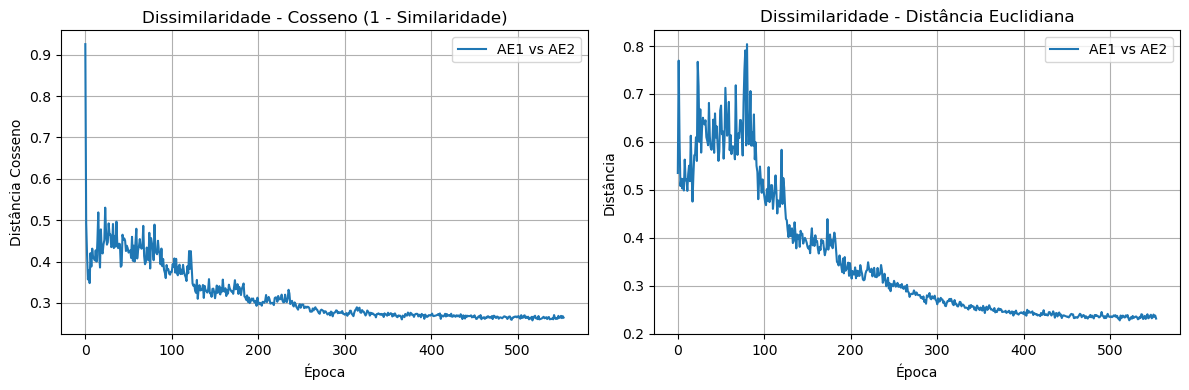

In [13]:
train_preds, train_labels, Z_AE1, Z_AE2 = treina_modelo(modelo_AE1, modelo_AE2, modelo_MLP, input_dim, device)

In [14]:
def testa(target_test, treino, labels_test):
  # Valida source
  modelo_AE1.eval()
  modelo_AE2.eval()
  modelo_MLP.eval()
  all_preds, all_labels, all_attacks = [], [], []

  with torch.no_grad():
      
    for (X, y), (z, y2) in zip(target_test, labels_test):

         X = X.to(device)
         y = y.to(device).float()
         y = y.view(-1, 1)
         z = z.to(device).float()
         z = z.view(-1, 1)
            
         # Forward do VAE1, VAE2
         recon1, x_latent1 = modelo_AE1(X)
         recon2, x_latent2 = modelo_AE2(X)
            
         # Classificação com vetor latente
         x_latent = torch.cat([x_latent1, x_latent2], dim=1)
         outputs = modelo_MLP(x_latent)
         loss_class = F.binary_cross_entropy(outputs, y)
               
         preds = (outputs > 0.5).float()

         # Calcula loss (BCE para binário)
         loss = F.binary_cross_entropy(outputs, y)
               
         all_preds.append(preds.cpu())
         all_labels.append(y.cpu())
         all_attacks.append(z.cpu())
        
  all_preds_list = torch.cat(all_preds)
  all_labels_list = torch.cat(all_labels)
  all_attacks_list = torch.cat(all_attacks)

  acc = (all_preds_list.view(-1) == all_labels_list.view(-1)).float().mean().item()

  # Matriz de confusão
  matriz2 = confusion_matrix(all_preds_list.numpy().round(), all_labels_list.numpy().round())
  sns.set(rc={"figure.figsize": (6, 6)})
  title = "Matriz de Confusão: " + treino
  sns.heatmap(matriz2/np.sum(matriz2), annot=True, annot_kws={'size': 10}, fmt='.2%', cmap='Blues').set_title(title)
  plt.show()

  # Extração dos elementos da matriz (para problema binário)
  TN, FP, FN, TP = matriz2.ravel()

  # Cálculo das métricas
  TPR = TP / (TP + FN) if (TP + FN) != 0 else 0  # Sensibilidade, Recall
  TNR = TN / (TN + FP) if (TN + FP) != 0 else 0  # Especificidade
  F1 = f1_score(all_labels_list.detach().numpy().round(), all_preds_list.detach().numpy().round())
  return TPR, TNR, F1, acc, all_preds_list.view(-1), all_labels_list.view(-1), all_attacks_list.view(-1)

Treinando com Ambos e validando com dataset1


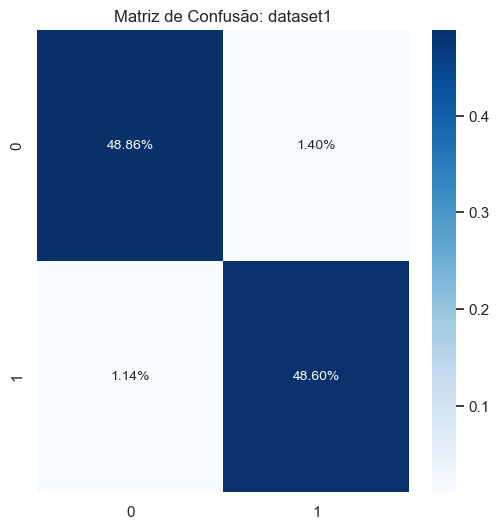

Treinando com Ambos e validando com dataset2


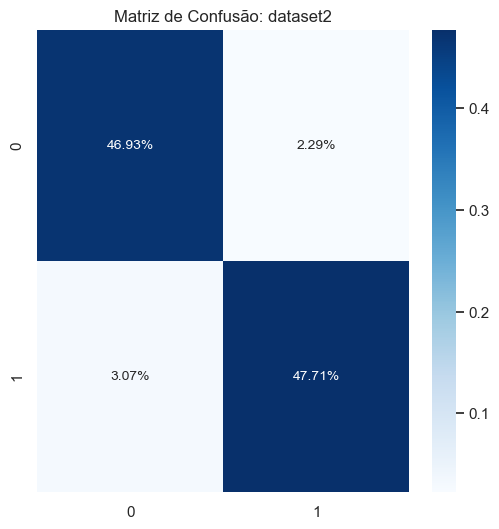

Treinando com Ambos e validando com dataset3


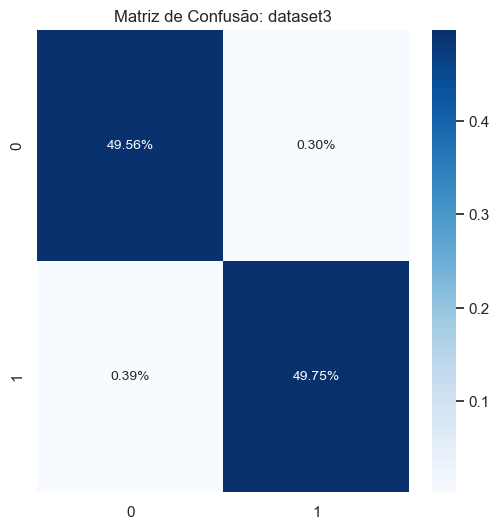

Treinando com Ambos e validando com dataset4


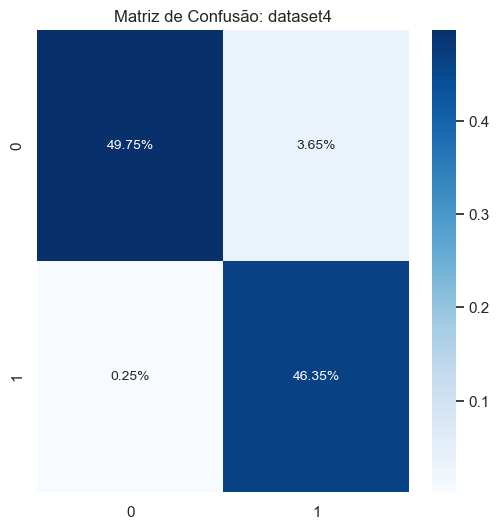

----------------------------------------------
Resumo da validação nos Datasets:
    Dataset       TPR       TNR  F1-Score  Acurácia
0  dataset1  0.977133  0.972117  0.974544  0.974612
1  dataset2  0.939591  0.953429  0.946816  0.946403
2  dataset3  0.992237  0.993980  0.993120  0.993106
3  dataset4  0.994699  0.931717  0.959697  0.961067
----------------------------------------------


In [15]:
datasets = ["dataset1", "dataset2", "dataset3", "dataset4"]
target_test = [loader_test1, loader_test2, loader_test3, loader_test4]
labels_test = [z_split_test1, z_split_test2, z_split_test3, z_split_test4]

TPRs = []
TNRs = []
F1s = []
ACCs = []
all_preds_lists = []
all_labels_lists = []
all_attacks_lists = []

for data, teste, labels  in zip(datasets, target_test, labels_test):
    print(f"Treinando com Ambos e validando com {data}")
    TPR, TNR, F1, acc, all_preds_list, all_labels_list, all_attacks_list = testa(teste, data, labels)
    TPRs.append(TPR)
    TNRs.append(TNR)
    F1s.append(F1)
    ACCs.append(acc)
    all_preds_lists.extend(all_preds_list)
    all_labels_lists.extend(all_labels_list)
    all_attacks_lists.extend(all_attacks_list)
    
# Criação da tabela
df = pd.DataFrame({
    'Dataset': datasets,
    'TPR': TPRs,
    'TNR': TNRs,
    'F1-Score': F1s,
    'Acurácia': ACCs
})
print("----------------------------------------------")
print("Resumo da validação nos Datasets:")
print(df)
print("----------------------------------------------")

In [16]:
# Combinar todas as predições em um dataframe para tabulação

all_labels = [t.item() for t in all_labels_lists]
all_preds = [t.item() for t in all_preds_lists]
all_attacks = [t.item() for t in all_attacks_lists]

# Inverter dicionario
map_attacks_inv = {v: k for k, v in map_attacks.items()}

df = pd.DataFrame({
    "Real": all_labels,
    "Previsto": all_preds,
    "Ataque": all_attacks
})

# Criar coluna de acerto/erro
df["Acertou"] = df["Real"] == df["Previsto"]

# Agrupar predições por tipo de ataque
tabela = df.groupby("Ataque").agg(
    Total=("Real","count"),
    Acertos=("Acertou","sum")
)

# Adicionar Acurácia por ataque
tabela["Acurácia"] = tabela["Acertos"] / tabela["Total"]

# Adicionar F1 por ataque
f1_por_ataque = {}
TP_por_ataque = {}
TN_por_ataque = {}
FP_por_ataque = {}
FN_por_ataque = {}
for atk, grupo in df.groupby("Ataque"):
    f1_por_ataque[atk] = f1_score(grupo["Real"], grupo["Previsto"], zero_division=0)
    TP_por_ataque[atk] = ((grupo["Real"] == 1) & (grupo["Previsto"] == 1)).sum()
    TN_por_ataque[atk] = ((grupo["Real"] == 0) & (grupo["Previsto"] == 0)).sum()
    FP_por_ataque[atk] = ((grupo["Real"] == 0) & (grupo["Previsto"] == 1)).sum()
    FN_por_ataque[atk] = ((grupo["Real"] == 1) & (grupo["Previsto"] == 0)).sum()

tabela["TP"] = tabela.index.map(TP_por_ataque)
tabela["TN"] = tabela.index.map(TN_por_ataque)
tabela["FP"] = tabela.index.map(FP_por_ataque)
tabela["FN"] = tabela.index.map(FN_por_ataque)
tabela["F1"] = tabela.index.map(f1_por_ataque)


# Renomear indice pelo nome do ataque
tabela.index = tabela.index.map(map_attacks_inv)

print("Resumo por tipo de ataque:")
print(tabela)

Resumo por tipo de ataque:
                          Total  Acertos  Acurácia    TP     TN    FP    FN  \
Ataque                                                                        
Benign                    61125    59543  0.974119     0  59543  1582     0   
dos                        8527     8497  0.996482  8497      0     0    30   
Reconnaissance             7409     7040  0.950196  7040      0     0   369   
ddos                       9825     9638  0.980967  9638      0     0   187   
Theft                       364      355  0.975275   355      0     0     9   
ransomware                  514      495  0.963035   495      0     0    19   
scanning                   2166     1724  0.795937  1724      0     0   442   
xss                        2167     2118  0.977388  2118      0     0    49   
mitm                       1158     1104  0.953368  1104      0     0    54   
password                   2167     2077  0.958468  2077      0     0    90   
backdoor                 

In [17]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

# Concatena os tensores
Z_AE1 = torch.cat(Z_AE1, dim=0) if isinstance(Z_AE1, list) else Z_AE1
Z_AE2 = torch.cat(Z_AE2, dim=0) if isinstance(Z_AE2, list) else Z_AE2

# Converte para numpy
Z_AE1_np = Z_AE1.detach().cpu().numpy()
Z_AE2_np = Z_AE2.detach().cpu().numpy()

# Define número máximo de amostras por classe
max_samples_per_class = 1500  # você pode ajustar esse número

def sample_array(arr, max_samples):
    if len(arr) > max_samples:
        idx = np.random.choice(len(arr), max_samples, replace=False)
        return arr[idx]
    return arr

# Amostragem balanceada
Z_AE1_s = sample_array(Z_AE1_np, max_samples_per_class)
Z_AE2_s = sample_array(Z_AE2_np, max_samples_per_class)

# Junta tudo
Z = np.concatenate([Z_AE1_s, Z_AE2_s])
labels = (
    ['AE1'] * len(Z_AE1_s) +
    ['AE2'] * len(Z_AE2_s) 
)

# Redução com t-SNE (ou troque por UMAP se quiser)
Z_embedded = TSNE(n_components=2, perplexity=30, random_state=42).fit_transform(Z)

# Visualização
plt.figure(figsize=(8, 6))
sns.scatterplot(x=Z_embedded[:, 0], y=Z_embedded[:, 1], hue=labels, palette="deep")
plt.title("t-SNE com amostragem balanceada")
plt.xlabel("Dim 1")
plt.ylabel("Dim 2")
plt.legend(title="Autoencoder")
plt.tight_layout()
plt.show()


RuntimeError: bad allocation